In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torchsummary import summary

from torch_geometric.datasets import ModelNet, ShapeNet
from torch_geometric.transforms import Compose, FixedPoints, SamplePoints, NormalizeScale
from torch_geometric.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
torch.__version__, device

('1.6.0+cu101', device(type='cuda'))

In [3]:
def visualize_mesh(pos, face):
    # from the tutorial https://colab.research.google.com/drive/1D45E5bUK3gQ40YpZo65ozs7hg5l-eo_U?usp=sharing#scrollTo=SvsEAR28LUI7
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=face.t(), antialiased=False)
    plt.show()


def visualize_points(points, ax=None, show_grid=False, is_shapenet=False):
    fig = plt.figure()
    if ax is None:
        ax = fig.gca(projection='3d')
    ax.patch.set_alpha(0)
    ax.view_init(elev=10., azim=240.)
    ax.grid(show_grid)
    if is_shapenet:
      ax.scatter(points[:,0], points[:,2], points[:,1], c=points[:,2], cmap='plasma', s=10)
    else:
      ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,1], cmap='plasma', s=10)
    

def visualize_real_and_generated_samples(samples, show_grid=False, is_shapenet=False):
    fig = plt.figure(figsize=(16, 8))
    for i, sample in enumerate(samples):
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        visualize_points(sample, ax, show_grid, is_shapenet)

## Process the data (ShapeNet or ModelNet)

In [4]:
shape_name = 'Table'

Processing...
Done!
ShapeNet(4423, categories=['Table'])
Data(category=[1], pos=[2778, 3], x=[2778, 3], y=[2778])
Data(category=[1], pos=[2742, 3], x=[2742, 3], y=[2742])


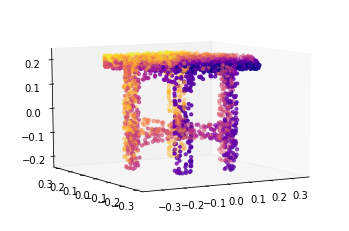

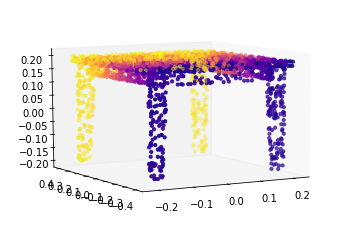

In [5]:
#dataset = ModelNet(root='E:\data\modelnet40_data', name='40')
#shape_label = 0
#dataset = CustomModelNet(root='.', name='40', pre_filter_target=lambda y: y == shape_label)

dataset = ShapeNet(root='E:/data/shapenet_data', categories=shape_name)


print(dataset)

data = dataset[0]
print(data)
# print(type(data.face), data.face)
# visualize_mesh(data.pos, data.face) # for ModelNet
visualize_points(data.pos, is_shapenet=True)


data = dataset[4]
print(data)
# visualize_mesh(data.pos, data.face) # for ModelNet
visualize_points(data.pos, is_shapenet=True)


### Normalize the position scale (for ModelNet) and sample and plot points

In [6]:
torch.manual_seed(11)

n_points = 2048 # number of points to sample
dataset.transform = FixedPoints(num=n_points) # samples points from a point cloud

# for ModelNet:
# SamplePoints samples points from a mesh
# dataset.transform = Compose([SamplePoints(num=n_points), NormalizeScale()])


Data(category=[1], pos=[2048, 3], x=[2048, 3], y=[2048])


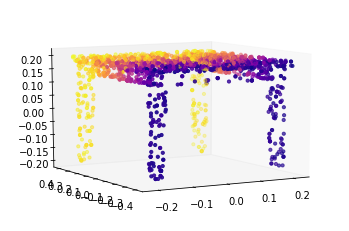

In [7]:
# sanity check:
data = dataset[4]
print(data)
visualize_points(data.pos, is_shapenet=True)

### Collect the data for a single class

In [8]:
# shape_label = 0
# single_class_data = dataset[dataset.data.y==shape_label]
single_class_data = dataset
n_shapes = len(single_class_data)
n_shapes

4423

## Raw GAN (r-GAN)

(See https://arxiv.org/pdf/1707.02392.pdf)

**Generator**

Input  128 --->  Linear 64 + ReLU  ---> Linear 128 + ReLU ---> Linear 512 + ReLU --->  Linear 1024 + ReLU  --->  Linear 2048*3

<br></br>

**Discriminator**

Input 2048x3 --->

ENCODER

Conv1D (2048, 64, kernel_size=1)   + LeakyReLU  --->  
Conv1D (64, 128, kernel_size=1)    + LeakyReLU --->
Conv1D (128, 256, kernel_size=1)   + LeakyReLU  --->
Conv1D (256, 256, kernel_size=1)   + LeakyReLU  --->
Conv1D (256, 512, kernel_size=1)   + LeakyReLU  --->
(output.shape = (512, 3))

--->

DECODER 

--->  Linear(512, 128) + ReLU ---> Linear(128, 64) + ReLU --->
--->  Linear(64, 1) + Sigmoid ---> Fake or Real


In [9]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True),
            nn.Linear(128, 512), nn.ReLU(True),
            nn.Linear(512, 1024), nn.ReLU(True),
            nn.Linear(1024, output_dim)
        )
        
    def forward(self, x):
        # reshape to batch_size x 3 x n_points
        samples = self.model(x).view(x.size(0), 3, -1)

        # TODO: try clipping the output to be in [-1, 1], e.g., by applying tanh
        # samples.clamp_(min=-1, max=1)

        return samples
    
    def init_params(self, layer):
        if type(layer) == nn.Linear:
            nn.init.xavier_uniform_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)

In [10]:
# instantiate the r-GAN generator
raw_gan_gen_input_dim = 128
raw_gan_gen = Generator(raw_gan_gen_input_dim, n_points*3).to(device)

# initialize the parameters:
raw_gan_gen.apply(raw_gan_gen.init_params)

mu = 0.
sigma = 0.2

z = torch.FloatTensor(1, raw_gan_gen_input_dim).normal_(mu, sigma).to(device)

print(z.shape)
print(raw_gan_gen(z).shape)

summary(raw_gan_gen, (1, raw_gan_gen_input_dim))

torch.Size([1, 128])
torch.Size([1, 3, 2048])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           8,256
              ReLU-2                [-1, 1, 64]               0
            Linear-3               [-1, 1, 128]           8,320
              ReLU-4               [-1, 1, 128]               0
            Linear-5               [-1, 1, 512]          66,048
              ReLU-6               [-1, 1, 512]               0
            Linear-7              [-1, 1, 1024]         525,312
              ReLU-8              [-1, 1, 1024]               0
            Linear-9              [-1, 1, 6144]       6,297,600
Total params: 6,905,536
Trainable params: 6,905,536
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 26.34
Estimated Total Size (MB

In [11]:
class Discriminator(nn.Module):
    def __init__(self, encoder_in_ch, encoder_out_ch):        
        super(Discriminator, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(encoder_in_ch, 64, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(128, 256, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(256, 256, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(256, encoder_out_ch, 1, 1), nn.LeakyReLU(0.2)
        )
        # outputs (batch_size x encoder_out_ch x n_points)
        # we then maxpool the output in the forward method, 
        # so the input to the decoder becomes (batch_size x encoder_out_ch)
        
        self.decoder = nn.Sequential(
            nn.Linear(encoder_out_ch, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True),
            nn.Linear(64, 1), nn.Sigmoid(),
        )
   

    def forward(self, x):
        x = self.encoder(x)
        x, _ = torch.max(x, dim=-1)
        x = self.decoder(x)
        return x
            
            
    def init_params(self, layer):
        if type(layer) == nn.Conv1d:
            nn.init.kaiming_uniform_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)            
        if type(layer) == nn.Linear:
            nn.init.xavier_uniform_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)

In [12]:
# instantiate the r-GAN discriminator:
raw_gan_dis_input_ch = 3
raw_gan_dis = Discriminator(raw_gan_dis_input_ch, 512).to(device)

# initialize the parameters:
raw_gan_dis.apply(raw_gan_dis.init_params)

# print the summary:
y = torch.ones((1, 3, 2048)).to(device)
print(y.shape)

pred = raw_gan_dis(y)
print(pred.shape)

summary(raw_gan_dis, (raw_gan_dis_input_ch, 2048))

torch.Size([1, 3, 2048])
torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2048]             256
         LeakyReLU-2             [-1, 64, 2048]               0
            Conv1d-3            [-1, 128, 2048]           8,320
         LeakyReLU-4            [-1, 128, 2048]               0
            Conv1d-5            [-1, 256, 2048]          33,024
         LeakyReLU-6            [-1, 256, 2048]               0
            Conv1d-7            [-1, 256, 2048]          65,792
         LeakyReLU-8            [-1, 256, 2048]               0
            Conv1d-9            [-1, 512, 2048]         131,584
        LeakyReLU-10            [-1, 512, 2048]               0
           Linear-11                  [-1, 128]          65,664
             ReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 64]           8

## Optimize the r-GAN

### Optimization setup

In [13]:
# hyperparameters:
lr_gen = 1e-4
lr_dis = 1e-4
beta1 = 0.5
beta2 = 0.999

# two separate optimizers for the generator and discriminator:
optimizer_gen = optim.Adam(params=raw_gan_gen.parameters(), 
                           lr=lr_gen, 
                           betas=(beta1, beta2))

optimizer_dis = optim.Adam(params=raw_gan_dis.parameters(), 
                           lr=lr_dis, 
                           betas=(beta1, beta2))

# by supplying with the correct labels, we will make it 
# equivalent to using non-saturating heuristic for the generator
# and the standard binary cross-entropy for the discriminator
criterion = nn.BCELoss().to(device)

### Create a dataloader for our single class dataset

In [14]:
batch_size = 50
dataloader = DataLoader(dataset=single_class_data, 
                        batch_size=batch_size, 
                        shuffle=True,
                        drop_last=True)

print('Batch size: ', batch_size)
print('Number of batches:', len(dataloader))

Batch size:  50
Number of batches: 88


### Training loop

In [15]:
epochs = 200
print_period = 10

losses_gen = []
losses_dis = []

for i in range(epochs):
    t0 = time.time()
    
    for batch_idx, batch_data in enumerate(dataloader):
        print(batch_idx, end='\r')
        batch_t0 = time.time()
        batch_size = batch_data.pos.shape[0] // n_points
        
        x = batch_data.pos.reshape(batch_size, n_points, 3).transpose(2, 1).to(device)
        
        # sample random vectors and generate samples from them:
        z = torch.FloatTensor(batch_size, raw_gan_gen_input_dim).normal_(mu, sigma).to(device)
        gen_samples = raw_gan_gen(z)
        
        # get the discriminator output for the two types of input:
        prob_x = raw_gan_dis(x)
        prob_gen_samples = raw_gan_dis(gen_samples)
        
        # the target probabilities:
        prob_real = torch.ones((batch_size, 1)).to(device)
        prob_fake = torch.zeros((batch_size, 1)).to(device)
        
        # the non-saturating heuristic loss for the generator:
        loss_gen = criterion(prob_gen_samples, prob_real)
        
        # compute the gradient of the loss_gen wrt the generator parameters:
        optimizer_gen.zero_grad()
        loss_gen.backward(retain_graph=True)
        
        # update the generator parameters:
        optimizer_gen.step()
        losses_gen.append(loss_gen.item())
                
        # the usual (binary cross-entropy) loss for the discriminator:
        loss_dis_real_term = criterion(prob_x, prob_real)
        loss_dis_fake_term = criterion(raw_gan_dis(gen_samples.detach()), prob_fake)
        loss_dis = loss_dis_real_term + loss_dis_fake_term
        
        # compute the gradient and update the discriminator parameters:
        optimizer_dis.zero_grad()
        loss_dis.backward()
        optimizer_dis.step()
        losses_dis.append(loss_dis.item())
        
        if batch_idx % print_period == 0:
            print('ETA: %.5f, epoch: %d/%d, batch: %d/%d, loss_gen: %.3f, loss_dis: %.3f'
              % (time.time() - batch_t0, i+1, epochs, batch_idx, len(dataloader), torch.mean(torch.FloatTensor(losses_gen)), torch.mean(torch.FloatTensor(losses_dis)))
            )
            
    print('ETA: %.5f' % (time.time() - t0), end='\n\n')   

ETA: 4.47613, epoch: 1/200, batch: 0/88, loss_gen: 0.657, loss_dis: 1.178
ETA: 3.92731, epoch: 1/200, batch: 10/88, loss_gen: 0.565, loss_dis: 1.089
ETA: 3.92566, epoch: 1/200, batch: 20/88, loss_gen: 0.526, loss_dis: 1.167
ETA: 3.92450, epoch: 1/200, batch: 30/88, loss_gen: 0.561, loss_dis: 1.213
ETA: 3.93289, epoch: 1/200, batch: 40/88, loss_gen: 0.599, loss_dis: 1.239
ETA: 3.91682, epoch: 1/200, batch: 50/88, loss_gen: 0.639, loss_dis: 1.249
ETA: 3.91481, epoch: 1/200, batch: 60/88, loss_gen: 0.663, loss_dis: 1.258
ETA: 3.92960, epoch: 1/200, batch: 70/88, loss_gen: 0.676, loss_dis: 1.266
ETA: 3.89953, epoch: 1/200, batch: 80/88, loss_gen: 0.686, loss_dis: 1.282
ETA: 324.64203

ETA: 3.89140, epoch: 2/200, batch: 0/88, loss_gen: 0.695, loss_dis: 1.284
ETA: 3.95756, epoch: 2/200, batch: 10/88, loss_gen: 0.704, loss_dis: 1.287
ETA: 3.96833, epoch: 2/200, batch: 20/88, loss_gen: 0.711, loss_dis: 1.283
ETA: 3.98016, epoch: 2/200, batch: 30/88, loss_gen: 0.711, loss_dis: 1.286
ETA: 3.9759

ETA: 3.78449, epoch: 12/200, batch: 80/88, loss_gen: 1.052, loss_dis: 0.987
ETA: 309.63018

ETA: 3.78898, epoch: 13/200, batch: 0/88, loss_gen: 1.052, loss_dis: 0.987
ETA: 3.79599, epoch: 13/200, batch: 10/88, loss_gen: 1.053, loss_dis: 0.987
ETA: 3.81601, epoch: 13/200, batch: 20/88, loss_gen: 1.054, loss_dis: 0.985
ETA: 3.80491, epoch: 13/200, batch: 30/88, loss_gen: 1.056, loss_dis: 0.984
ETA: 3.78002, epoch: 13/200, batch: 40/88, loss_gen: 1.058, loss_dis: 0.982
ETA: 3.79254, epoch: 13/200, batch: 50/88, loss_gen: 1.059, loss_dis: 0.981
ETA: 3.80895, epoch: 13/200, batch: 60/88, loss_gen: 1.060, loss_dis: 0.979
ETA: 3.78774, epoch: 13/200, batch: 70/88, loss_gen: 1.062, loss_dis: 0.977
ETA: 3.85126, epoch: 13/200, batch: 80/88, loss_gen: 1.063, loss_dis: 0.976
ETA: 309.71336

ETA: 3.78956, epoch: 14/200, batch: 0/88, loss_gen: 1.064, loss_dis: 0.976
ETA: 3.79764, epoch: 14/200, batch: 10/88, loss_gen: 1.066, loss_dis: 0.974
ETA: 3.80194, epoch: 14/200, batch: 20/88, loss_gen: 1.068

ETA: 3.74519, epoch: 24/200, batch: 60/88, loss_gen: 1.117, loss_dis: 0.964
ETA: 3.71496, epoch: 24/200, batch: 70/88, loss_gen: 1.116, loss_dis: 0.965
ETA: 3.71409, epoch: 24/200, batch: 80/88, loss_gen: 1.115, loss_dis: 0.966
ETA: 304.95909

ETA: 3.71166, epoch: 25/200, batch: 0/88, loss_gen: 1.114, loss_dis: 0.967
ETA: 3.69531, epoch: 25/200, batch: 10/88, loss_gen: 1.113, loss_dis: 0.968
ETA: 3.72492, epoch: 25/200, batch: 20/88, loss_gen: 1.112, loss_dis: 0.969
ETA: 3.72940, epoch: 25/200, batch: 30/88, loss_gen: 1.111, loss_dis: 0.970
ETA: 3.73364, epoch: 25/200, batch: 40/88, loss_gen: 1.110, loss_dis: 0.971
ETA: 3.65487, epoch: 25/200, batch: 50/88, loss_gen: 1.109, loss_dis: 0.972
ETA: 3.62876, epoch: 25/200, batch: 60/88, loss_gen: 1.108, loss_dis: 0.973
ETA: 3.65393, epoch: 25/200, batch: 70/88, loss_gen: 1.107, loss_dis: 0.974
ETA: 3.69225, epoch: 25/200, batch: 80/88, loss_gen: 1.106, loss_dis: 0.975
ETA: 303.46697

ETA: 3.76712, epoch: 26/200, batch: 0/88, loss_gen: 1.106

ETA: 3.55282, epoch: 36/200, batch: 40/88, loss_gen: 1.038, loss_dis: 1.049
ETA: 3.55780, epoch: 36/200, batch: 50/88, loss_gen: 1.038, loss_dis: 1.049
ETA: 3.57999, epoch: 36/200, batch: 60/88, loss_gen: 1.037, loss_dis: 1.050
ETA: 3.54954, epoch: 36/200, batch: 70/88, loss_gen: 1.037, loss_dis: 1.051
ETA: 3.56442, epoch: 36/200, batch: 80/88, loss_gen: 1.036, loss_dis: 1.051
ETA: 289.95494

ETA: 3.54933, epoch: 37/200, batch: 0/88, loss_gen: 1.036, loss_dis: 1.052
ETA: 3.59429, epoch: 37/200, batch: 10/88, loss_gen: 1.035, loss_dis: 1.052
ETA: 3.55488, epoch: 37/200, batch: 20/88, loss_gen: 1.035, loss_dis: 1.053
ETA: 3.56439, epoch: 37/200, batch: 30/88, loss_gen: 1.034, loss_dis: 1.054
ETA: 3.54991, epoch: 37/200, batch: 40/88, loss_gen: 1.034, loss_dis: 1.054
ETA: 3.55879, epoch: 37/200, batch: 50/88, loss_gen: 1.033, loss_dis: 1.055
ETA: 3.56379, epoch: 37/200, batch: 60/88, loss_gen: 1.033, loss_dis: 1.055
ETA: 3.55455, epoch: 37/200, batch: 70/88, loss_gen: 1.032, loss_dis: 1.0

ETA: 3.54109, epoch: 48/200, batch: 20/88, loss_gen: 0.989, loss_dis: 1.104
ETA: 3.56538, epoch: 48/200, batch: 30/88, loss_gen: 0.988, loss_dis: 1.104
ETA: 3.57959, epoch: 48/200, batch: 40/88, loss_gen: 0.988, loss_dis: 1.105
ETA: 3.56186, epoch: 48/200, batch: 50/88, loss_gen: 0.988, loss_dis: 1.105
ETA: 3.56106, epoch: 48/200, batch: 60/88, loss_gen: 0.987, loss_dis: 1.106
ETA: 3.55290, epoch: 48/200, batch: 70/88, loss_gen: 0.987, loss_dis: 1.106
ETA: 3.54644, epoch: 48/200, batch: 80/88, loss_gen: 0.986, loss_dis: 1.106
ETA: 290.10416

ETA: 3.55800, epoch: 49/200, batch: 0/88, loss_gen: 0.986, loss_dis: 1.107
ETA: 3.56620, epoch: 49/200, batch: 10/88, loss_gen: 0.986, loss_dis: 1.107
ETA: 3.55599, epoch: 49/200, batch: 20/88, loss_gen: 0.985, loss_dis: 1.108
ETA: 3.55533, epoch: 49/200, batch: 30/88, loss_gen: 0.985, loss_dis: 1.108
ETA: 3.56771, epoch: 49/200, batch: 40/88, loss_gen: 0.985, loss_dis: 1.108
ETA: 3.56249, epoch: 49/200, batch: 50/88, loss_gen: 0.984, loss_dis: 1.1

ETA: 291.08385

ETA: 3.57526, epoch: 60/200, batch: 0/88, loss_gen: 0.953, loss_dis: 1.143
ETA: 3.58717, epoch: 60/200, batch: 10/88, loss_gen: 0.953, loss_dis: 1.143
ETA: 3.57014, epoch: 60/200, batch: 20/88, loss_gen: 0.953, loss_dis: 1.143
ETA: 3.60104, epoch: 60/200, batch: 30/88, loss_gen: 0.953, loss_dis: 1.144
ETA: 3.56141, epoch: 60/200, batch: 40/88, loss_gen: 0.952, loss_dis: 1.144
ETA: 3.56721, epoch: 60/200, batch: 50/88, loss_gen: 0.952, loss_dis: 1.144
ETA: 3.56616, epoch: 60/200, batch: 60/88, loss_gen: 0.952, loss_dis: 1.145
ETA: 3.57174, epoch: 60/200, batch: 70/88, loss_gen: 0.951, loss_dis: 1.145
ETA: 3.55989, epoch: 60/200, batch: 80/88, loss_gen: 0.951, loss_dis: 1.145
ETA: 290.71156

ETA: 3.56526, epoch: 61/200, batch: 0/88, loss_gen: 0.951, loss_dis: 1.145
ETA: 3.56814, epoch: 61/200, batch: 10/88, loss_gen: 0.951, loss_dis: 1.146
ETA: 3.55023, epoch: 61/200, batch: 20/88, loss_gen: 0.950, loss_dis: 1.146
ETA: 3.55866, epoch: 61/200, batch: 30/88, loss_gen: 0.950

ETA: 3.43962, epoch: 71/200, batch: 70/88, loss_gen: 0.927, loss_dis: 1.170
ETA: 3.66338, epoch: 71/200, batch: 80/88, loss_gen: 0.927, loss_dis: 1.170
ETA: 275.93205

ETA: 3.54318, epoch: 72/200, batch: 0/88, loss_gen: 0.927, loss_dis: 1.170
ETA: 3.48676, epoch: 72/200, batch: 10/88, loss_gen: 0.927, loss_dis: 1.171
ETA: 3.44333, epoch: 72/200, batch: 20/88, loss_gen: 0.926, loss_dis: 1.171
ETA: 3.64070, epoch: 72/200, batch: 30/88, loss_gen: 0.926, loss_dis: 1.171
ETA: 3.47577, epoch: 72/200, batch: 40/88, loss_gen: 0.926, loss_dis: 1.171
ETA: 3.47431, epoch: 72/200, batch: 50/88, loss_gen: 0.926, loss_dis: 1.172
ETA: 3.45895, epoch: 72/200, batch: 60/88, loss_gen: 0.926, loss_dis: 1.172
ETA: 3.46785, epoch: 72/200, batch: 70/88, loss_gen: 0.925, loss_dis: 1.172
ETA: 3.44462, epoch: 72/200, batch: 80/88, loss_gen: 0.925, loss_dis: 1.172
ETA: 276.91843

ETA: 3.45323, epoch: 73/200, batch: 0/88, loss_gen: 0.925, loss_dis: 1.173
ETA: 3.46907, epoch: 73/200, batch: 10/88, loss_gen: 0.925

ETA: 4.60099, epoch: 83/200, batch: 50/88, loss_gen: 0.909, loss_dis: 1.190
ETA: 4.66396, epoch: 83/200, batch: 60/88, loss_gen: 0.908, loss_dis: 1.190
ETA: 4.56382, epoch: 83/200, batch: 70/88, loss_gen: 0.908, loss_dis: 1.190
ETA: 4.60784, epoch: 83/200, batch: 80/88, loss_gen: 0.908, loss_dis: 1.190
ETA: 382.52852

ETA: 4.55650, epoch: 84/200, batch: 0/88, loss_gen: 0.908, loss_dis: 1.190
ETA: 4.57181, epoch: 84/200, batch: 10/88, loss_gen: 0.908, loss_dis: 1.191
ETA: 4.60530, epoch: 84/200, batch: 20/88, loss_gen: 0.908, loss_dis: 1.191
ETA: 4.57326, epoch: 84/200, batch: 30/88, loss_gen: 0.907, loss_dis: 1.191
ETA: 4.73126, epoch: 84/200, batch: 40/88, loss_gen: 0.907, loss_dis: 1.191
ETA: 4.46879, epoch: 84/200, batch: 50/88, loss_gen: 0.907, loss_dis: 1.191
ETA: 4.61950, epoch: 84/200, batch: 60/88, loss_gen: 0.907, loss_dis: 1.191
ETA: 4.56769, epoch: 84/200, batch: 70/88, loss_gen: 0.907, loss_dis: 1.191
ETA: 4.58701, epoch: 84/200, batch: 80/88, loss_gen: 0.907, loss_dis: 1.1

ETA: 3.79878, epoch: 95/200, batch: 30/88, loss_gen: 0.894, loss_dis: 1.204
ETA: 3.80373, epoch: 95/200, batch: 40/88, loss_gen: 0.894, loss_dis: 1.204
ETA: 3.78238, epoch: 95/200, batch: 50/88, loss_gen: 0.894, loss_dis: 1.205
ETA: 3.80955, epoch: 95/200, batch: 60/88, loss_gen: 0.894, loss_dis: 1.205
ETA: 3.80064, epoch: 95/200, batch: 70/88, loss_gen: 0.894, loss_dis: 1.205
ETA: 3.78677, epoch: 95/200, batch: 80/88, loss_gen: 0.893, loss_dis: 1.205
ETA: 316.12948

ETA: 3.76701, epoch: 96/200, batch: 0/88, loss_gen: 0.893, loss_dis: 1.205
ETA: 3.80117, epoch: 96/200, batch: 10/88, loss_gen: 0.893, loss_dis: 1.205
ETA: 3.80402, epoch: 96/200, batch: 20/88, loss_gen: 0.893, loss_dis: 1.205
ETA: 3.52288, epoch: 96/200, batch: 30/88, loss_gen: 0.893, loss_dis: 1.205
ETA: 3.51783, epoch: 96/200, batch: 40/88, loss_gen: 0.893, loss_dis: 1.206
ETA: 3.49675, epoch: 96/200, batch: 50/88, loss_gen: 0.893, loss_dis: 1.206
ETA: 3.51023, epoch: 96/200, batch: 60/88, loss_gen: 0.893, loss_dis: 1.2

ETA: 253.54183

ETA: 3.08657, epoch: 107/200, batch: 0/88, loss_gen: 0.884, loss_dis: 1.215
ETA: 3.07463, epoch: 107/200, batch: 10/88, loss_gen: 0.884, loss_dis: 1.215
ETA: 3.08989, epoch: 107/200, batch: 20/88, loss_gen: 0.883, loss_dis: 1.216
ETA: 3.06929, epoch: 107/200, batch: 30/88, loss_gen: 0.883, loss_dis: 1.216
ETA: 3.08767, epoch: 107/200, batch: 40/88, loss_gen: 0.883, loss_dis: 1.216
ETA: 3.07617, epoch: 107/200, batch: 50/88, loss_gen: 0.883, loss_dis: 1.216
ETA: 3.08969, epoch: 107/200, batch: 60/88, loss_gen: 0.883, loss_dis: 1.216
ETA: 3.08823, epoch: 107/200, batch: 70/88, loss_gen: 0.883, loss_dis: 1.216
ETA: 3.08493, epoch: 107/200, batch: 80/88, loss_gen: 0.883, loss_dis: 1.216
ETA: 253.02663

ETA: 3.10334, epoch: 108/200, batch: 0/88, loss_gen: 0.883, loss_dis: 1.216
ETA: 3.10765, epoch: 108/200, batch: 10/88, loss_gen: 0.883, loss_dis: 1.216
ETA: 3.08911, epoch: 108/200, batch: 20/88, loss_gen: 0.883, loss_dis: 1.216
ETA: 3.07220, epoch: 108/200, batch: 30/88, lo

ETA: 3.09231, epoch: 118/200, batch: 60/88, loss_gen: 0.876, loss_dis: 1.223
ETA: 3.08172, epoch: 118/200, batch: 70/88, loss_gen: 0.876, loss_dis: 1.224
ETA: 3.07942, epoch: 118/200, batch: 80/88, loss_gen: 0.875, loss_dis: 1.224
ETA: 253.18088

ETA: 3.09448, epoch: 119/200, batch: 0/88, loss_gen: 0.875, loss_dis: 1.224
ETA: 3.08226, epoch: 119/200, batch: 10/88, loss_gen: 0.875, loss_dis: 1.224
ETA: 3.08885, epoch: 119/200, batch: 20/88, loss_gen: 0.875, loss_dis: 1.224
ETA: 3.08285, epoch: 119/200, batch: 30/88, loss_gen: 0.875, loss_dis: 1.224
ETA: 3.09605, epoch: 119/200, batch: 40/88, loss_gen: 0.875, loss_dis: 1.224
ETA: 3.08409, epoch: 119/200, batch: 50/88, loss_gen: 0.875, loss_dis: 1.224
ETA: 3.08819, epoch: 119/200, batch: 60/88, loss_gen: 0.875, loss_dis: 1.224
ETA: 3.08223, epoch: 119/200, batch: 70/88, loss_gen: 0.875, loss_dis: 1.224
ETA: 3.07502, epoch: 119/200, batch: 80/88, loss_gen: 0.875, loss_dis: 1.224
ETA: 253.02051

ETA: 3.08443, epoch: 120/200, batch: 0/88, lo

ETA: 3.08797, epoch: 130/200, batch: 30/88, loss_gen: 0.869, loss_dis: 1.230
ETA: 3.07026, epoch: 130/200, batch: 40/88, loss_gen: 0.869, loss_dis: 1.230
ETA: 3.08946, epoch: 130/200, batch: 50/88, loss_gen: 0.869, loss_dis: 1.230
ETA: 3.09233, epoch: 130/200, batch: 60/88, loss_gen: 0.869, loss_dis: 1.230
ETA: 3.09085, epoch: 130/200, batch: 70/88, loss_gen: 0.869, loss_dis: 1.230
ETA: 3.08237, epoch: 130/200, batch: 80/88, loss_gen: 0.869, loss_dis: 1.230
ETA: 252.68366

ETA: 3.08237, epoch: 131/200, batch: 0/88, loss_gen: 0.869, loss_dis: 1.230
ETA: 3.08871, epoch: 131/200, batch: 10/88, loss_gen: 0.869, loss_dis: 1.230
ETA: 3.07613, epoch: 131/200, batch: 20/88, loss_gen: 0.869, loss_dis: 1.230
ETA: 3.07704, epoch: 131/200, batch: 30/88, loss_gen: 0.869, loss_dis: 1.230
ETA: 3.08096, epoch: 131/200, batch: 40/88, loss_gen: 0.869, loss_dis: 1.230
ETA: 3.07767, epoch: 131/200, batch: 50/88, loss_gen: 0.869, loss_dis: 1.230
ETA: 3.11326, epoch: 131/200, batch: 60/88, loss_gen: 0.869, 

ETA: 253.10974

ETA: 3.08401, epoch: 142/200, batch: 0/88, loss_gen: 0.864, loss_dis: 1.234
ETA: 3.08870, epoch: 142/200, batch: 10/88, loss_gen: 0.864, loss_dis: 1.234
ETA: 3.08979, epoch: 142/200, batch: 20/88, loss_gen: 0.864, loss_dis: 1.234
ETA: 3.09193, epoch: 142/200, batch: 30/88, loss_gen: 0.864, loss_dis: 1.234
ETA: 3.09546, epoch: 142/200, batch: 40/88, loss_gen: 0.864, loss_dis: 1.234
ETA: 3.08460, epoch: 142/200, batch: 50/88, loss_gen: 0.864, loss_dis: 1.234
ETA: 3.09044, epoch: 142/200, batch: 60/88, loss_gen: 0.864, loss_dis: 1.234
ETA: 3.07401, epoch: 142/200, batch: 70/88, loss_gen: 0.864, loss_dis: 1.234
ETA: 3.09329, epoch: 142/200, batch: 80/88, loss_gen: 0.864, loss_dis: 1.234
ETA: 253.24141

ETA: 3.08327, epoch: 143/200, batch: 0/88, loss_gen: 0.864, loss_dis: 1.234
ETA: 3.08438, epoch: 143/200, batch: 10/88, loss_gen: 0.864, loss_dis: 1.235
ETA: 3.11575, epoch: 143/200, batch: 20/88, loss_gen: 0.864, loss_dis: 1.235
ETA: 3.08111, epoch: 143/200, batch: 30/88, lo

ETA: 3.10241, epoch: 153/200, batch: 60/88, loss_gen: 0.861, loss_dis: 1.237
ETA: 3.09101, epoch: 153/200, batch: 70/88, loss_gen: 0.861, loss_dis: 1.237
ETA: 3.06716, epoch: 153/200, batch: 80/88, loss_gen: 0.861, loss_dis: 1.238
ETA: 253.07148

ETA: 3.07991, epoch: 154/200, batch: 0/88, loss_gen: 0.861, loss_dis: 1.238
ETA: 3.11509, epoch: 154/200, batch: 10/88, loss_gen: 0.861, loss_dis: 1.238
ETA: 3.08605, epoch: 154/200, batch: 20/88, loss_gen: 0.861, loss_dis: 1.238
ETA: 3.09316, epoch: 154/200, batch: 30/88, loss_gen: 0.861, loss_dis: 1.238
ETA: 3.07181, epoch: 154/200, batch: 40/88, loss_gen: 0.861, loss_dis: 1.238
ETA: 3.10411, epoch: 154/200, batch: 50/88, loss_gen: 0.861, loss_dis: 1.238
ETA: 3.06867, epoch: 154/200, batch: 60/88, loss_gen: 0.861, loss_dis: 1.238
ETA: 3.08615, epoch: 154/200, batch: 70/88, loss_gen: 0.861, loss_dis: 1.238
ETA: 3.08515, epoch: 154/200, batch: 80/88, loss_gen: 0.861, loss_dis: 1.238
ETA: 253.19444

ETA: 3.07994, epoch: 155/200, batch: 0/88, lo

ETA: 3.08837, epoch: 165/200, batch: 30/88, loss_gen: 0.858, loss_dis: 1.241
ETA: 3.08647, epoch: 165/200, batch: 40/88, loss_gen: 0.858, loss_dis: 1.241
ETA: 3.08046, epoch: 165/200, batch: 50/88, loss_gen: 0.858, loss_dis: 1.241
ETA: 3.07131, epoch: 165/200, batch: 60/88, loss_gen: 0.858, loss_dis: 1.241
ETA: 3.07984, epoch: 165/200, batch: 70/88, loss_gen: 0.858, loss_dis: 1.241
ETA: 3.07592, epoch: 165/200, batch: 80/88, loss_gen: 0.858, loss_dis: 1.241
ETA: 253.11526

ETA: 3.07021, epoch: 166/200, batch: 0/88, loss_gen: 0.858, loss_dis: 1.241
ETA: 3.09682, epoch: 166/200, batch: 10/88, loss_gen: 0.858, loss_dis: 1.241
ETA: 3.09160, epoch: 166/200, batch: 20/88, loss_gen: 0.858, loss_dis: 1.241
ETA: 3.08456, epoch: 166/200, batch: 30/88, loss_gen: 0.858, loss_dis: 1.241
ETA: 3.08379, epoch: 166/200, batch: 40/88, loss_gen: 0.858, loss_dis: 1.241
ETA: 3.09418, epoch: 166/200, batch: 50/88, loss_gen: 0.858, loss_dis: 1.241
ETA: 3.08817, epoch: 166/200, batch: 60/88, loss_gen: 0.858, 

ETA: 253.18182

ETA: 3.09619, epoch: 177/200, batch: 0/88, loss_gen: 0.856, loss_dis: 1.243
ETA: 3.08736, epoch: 177/200, batch: 10/88, loss_gen: 0.856, loss_dis: 1.243
ETA: 3.08131, epoch: 177/200, batch: 20/88, loss_gen: 0.856, loss_dis: 1.243
ETA: 3.09651, epoch: 177/200, batch: 30/88, loss_gen: 0.856, loss_dis: 1.243
ETA: 3.08787, epoch: 177/200, batch: 40/88, loss_gen: 0.855, loss_dis: 1.243
ETA: 3.10140, epoch: 177/200, batch: 50/88, loss_gen: 0.855, loss_dis: 1.243
ETA: 3.07412, epoch: 177/200, batch: 60/88, loss_gen: 0.855, loss_dis: 1.243
ETA: 3.08756, epoch: 177/200, batch: 70/88, loss_gen: 0.855, loss_dis: 1.243
ETA: 3.08975, epoch: 177/200, batch: 80/88, loss_gen: 0.855, loss_dis: 1.243
ETA: 253.40123

ETA: 3.07794, epoch: 178/200, batch: 0/88, loss_gen: 0.855, loss_dis: 1.243
ETA: 3.11534, epoch: 178/200, batch: 10/88, loss_gen: 0.855, loss_dis: 1.243
ETA: 3.08882, epoch: 178/200, batch: 20/88, loss_gen: 0.855, loss_dis: 1.244
ETA: 3.07906, epoch: 178/200, batch: 30/88, lo

ETA: 3.09673, epoch: 188/200, batch: 60/88, loss_gen: 0.854, loss_dis: 1.245
ETA: 3.07357, epoch: 188/200, batch: 70/88, loss_gen: 0.854, loss_dis: 1.245
ETA: 3.08564, epoch: 188/200, batch: 80/88, loss_gen: 0.854, loss_dis: 1.245
ETA: 253.19515

ETA: 3.08849, epoch: 189/200, batch: 0/88, loss_gen: 0.854, loss_dis: 1.245
ETA: 3.09040, epoch: 189/200, batch: 10/88, loss_gen: 0.854, loss_dis: 1.245
ETA: 3.07991, epoch: 189/200, batch: 20/88, loss_gen: 0.854, loss_dis: 1.245
ETA: 3.08093, epoch: 189/200, batch: 30/88, loss_gen: 0.854, loss_dis: 1.245
ETA: 3.08869, epoch: 189/200, batch: 40/88, loss_gen: 0.854, loss_dis: 1.245
ETA: 3.08266, epoch: 189/200, batch: 50/88, loss_gen: 0.854, loss_dis: 1.245
ETA: 3.09085, epoch: 189/200, batch: 60/88, loss_gen: 0.854, loss_dis: 1.245
ETA: 3.08532, epoch: 189/200, batch: 70/88, loss_gen: 0.854, loss_dis: 1.245
ETA: 3.07951, epoch: 189/200, batch: 80/88, loss_gen: 0.854, loss_dis: 1.245
ETA: 253.25396

ETA: 3.08582, epoch: 190/200, batch: 0/88, lo

ETA: 3.08092, epoch: 200/200, batch: 30/88, loss_gen: 0.853, loss_dis: 1.246
ETA: 3.11563, epoch: 200/200, batch: 40/88, loss_gen: 0.853, loss_dis: 1.246
ETA: 3.10228, epoch: 200/200, batch: 50/88, loss_gen: 0.853, loss_dis: 1.246
ETA: 3.08037, epoch: 200/200, batch: 60/88, loss_gen: 0.853, loss_dis: 1.246
ETA: 3.08221, epoch: 200/200, batch: 70/88, loss_gen: 0.853, loss_dis: 1.246
ETA: 3.09839, epoch: 200/200, batch: 80/88, loss_gen: 0.853, loss_dis: 1.246
ETA: 253.22125



### Plot the losses

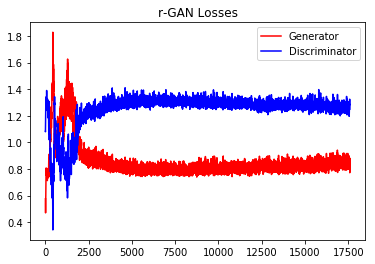

In [16]:
def running_mean(data, periods=10):
    # from https://github.com/artemsavkin/latent3d/blob/master/pcl_latent3d_shapenet.ipynb
    weights = np.ones(periods) / periods
    return np.convolve(data, weights, mode='valid')

rm_losses_gen = running_mean(np.asarray(losses_gen))
rm_losses_dis = running_mean(np.asarray(losses_dis))


plt.plot(range(0, len(rm_losses_gen)), rm_losses_gen, 'r-', label='Generator')
plt.plot(range(0, len(rm_losses_dis)), rm_losses_dis, 'b-', label='Discriminator')
plt.gca().patch.set_alpha(0)
plt.title('r-GAN Losses')
plt.legend()
plt.show()

## Save the model

In [17]:

torch.save(
    {
      'raw_gan_generator': raw_gan_gen.state_dict(),
      'raw_gan_discriminator': raw_gan_dis.state_dict()
    },
    shape_name+'_raw_gan.tar'
    )


In [18]:
loaded_model = torch.load(shape_name+'_raw_gan.tar', map_location=device)
loaded_model['raw_gan_generator']

OrderedDict([('model.0.weight',
              tensor([[ 0.1585,  0.0627,  0.0860,  ..., -0.0713, -0.1014,  0.1037],
                      [-0.1555,  0.0662,  0.0325,  ...,  0.0576,  0.0630,  0.0741],
                      [-0.0770, -0.0519,  0.0589,  ...,  0.0252, -0.1391, -0.0914],
                      ...,
                      [ 0.1322,  0.1256,  0.1738,  ..., -0.0529, -0.0273,  0.1071],
                      [ 0.0521, -0.0015,  0.1173,  ..., -0.1096, -0.0507,  0.1350],
                      [ 0.0286,  0.0908,  0.0087,  ...,  0.0568, -0.1643,  0.0629]],
                     device='cuda:0')),
             ('model.0.bias',
              tensor([-0.0292, -0.0672,  0.0233,  0.0044, -0.0019, -0.0650, -0.0057, -0.0040,
                      -0.0075,  0.0296, -0.0823, -0.0039,  0.0074, -0.0102,  0.0362, -0.0394,
                       0.0449, -0.0345,  0.0249,  0.0189,  0.0437,  0.0020,  0.0156,  0.0092,
                       0.0012,  0.0536,  0.0527, -0.0156,  0.0237,  0.0058, -0.0393,

### Generate samples

(50, 3, 2048)
(50, 3, 2048)


E:\Programms\anaconda3\envs\embedme\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


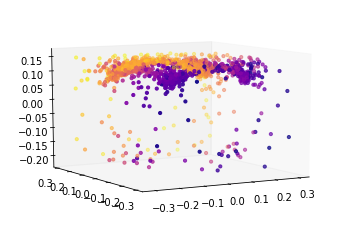

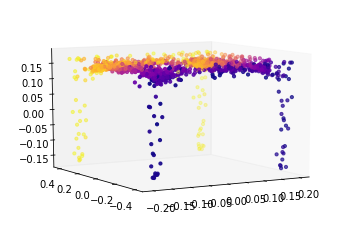

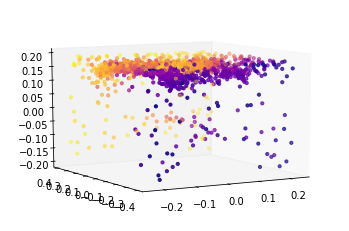

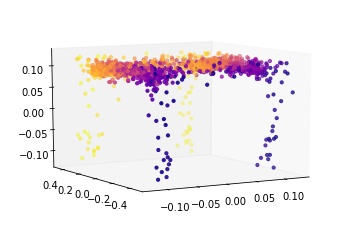

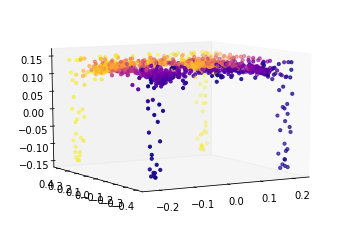

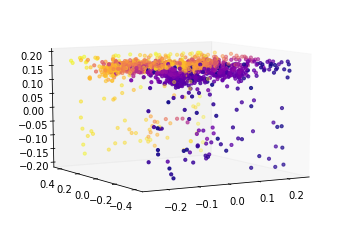

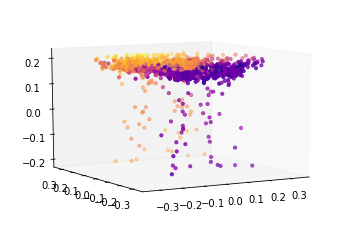

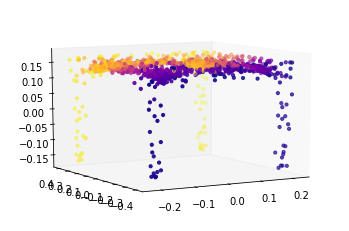

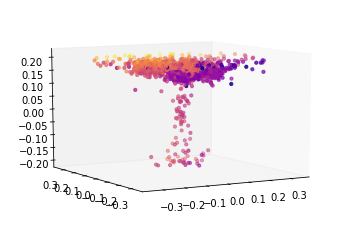

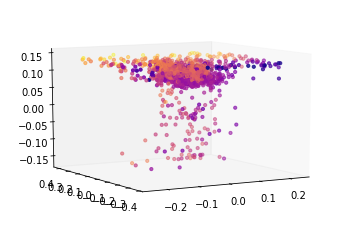

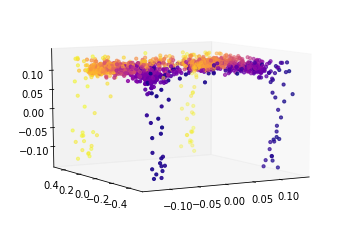

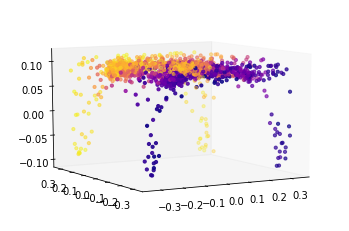

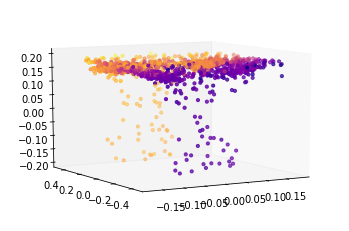

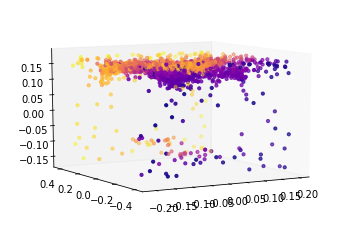

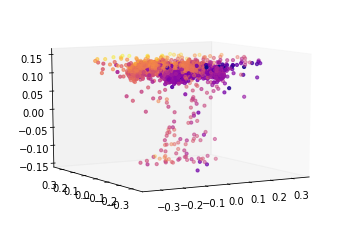

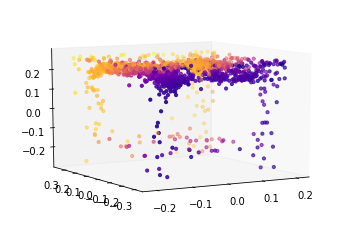

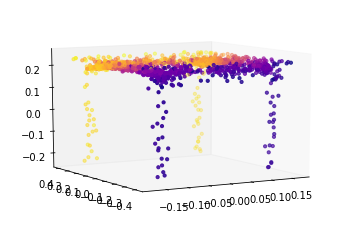

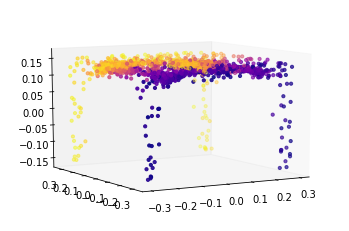

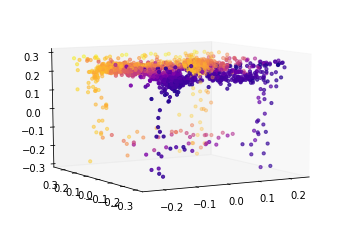

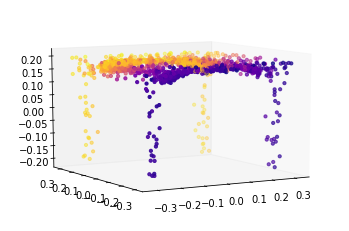

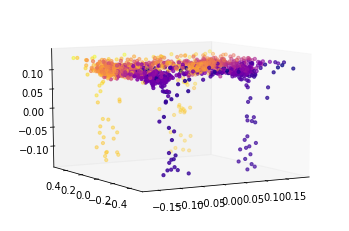

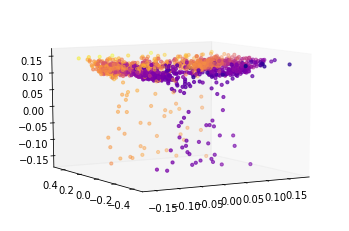

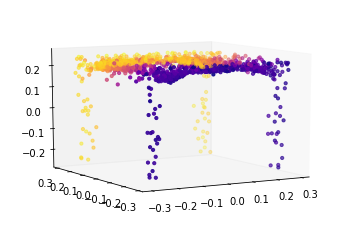

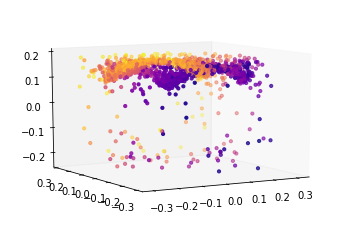

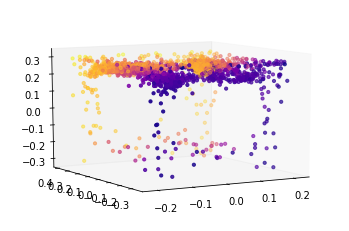

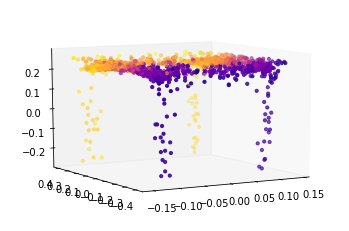

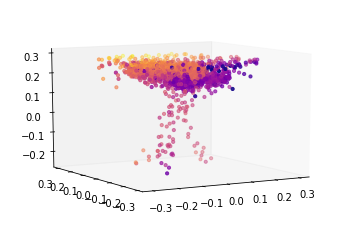

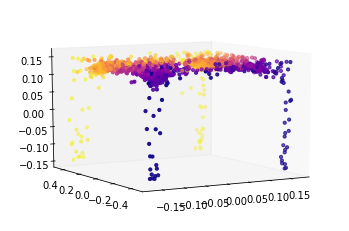

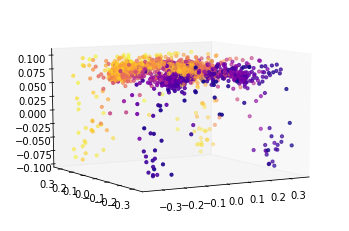

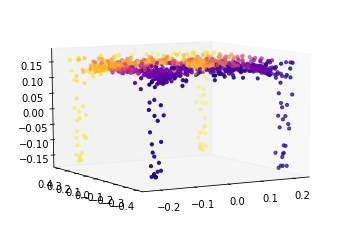

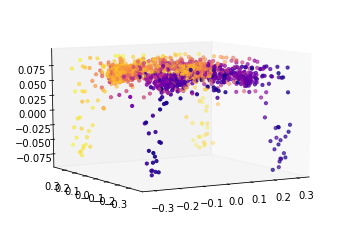

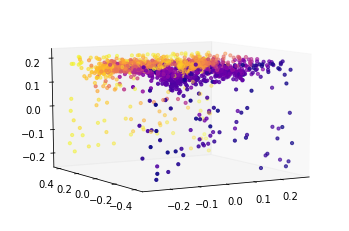

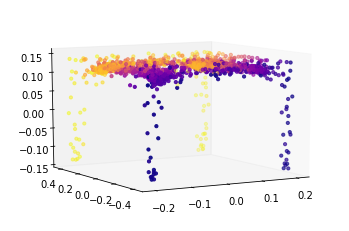

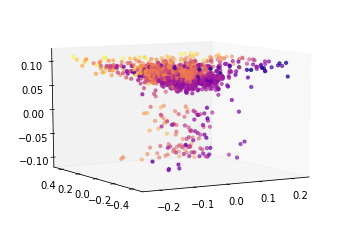

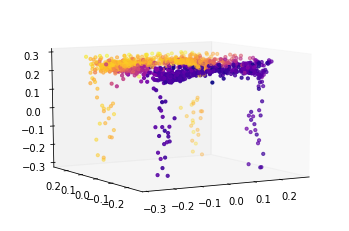

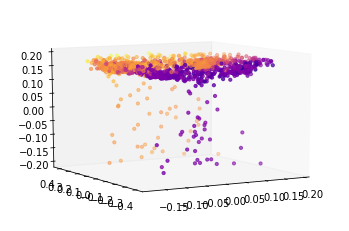

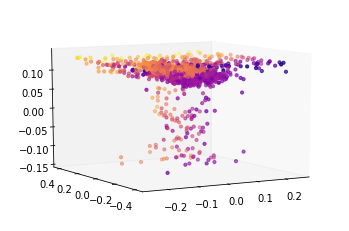

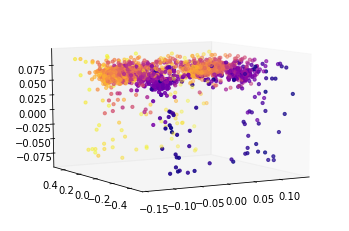

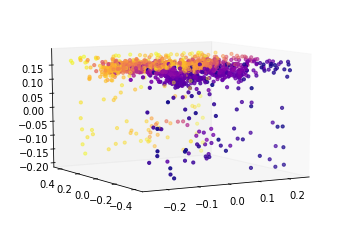

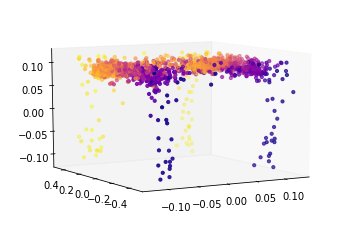

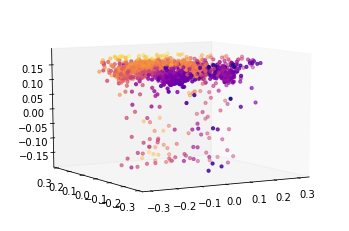

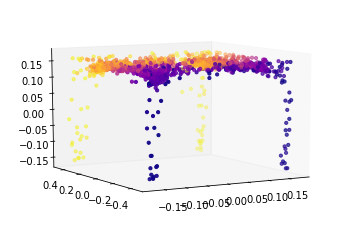

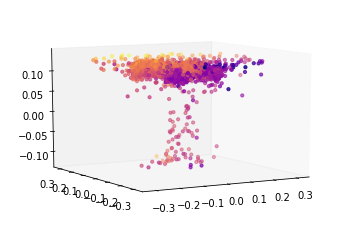

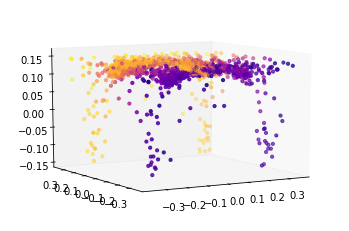

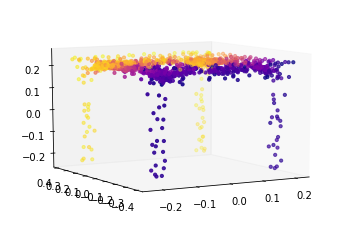

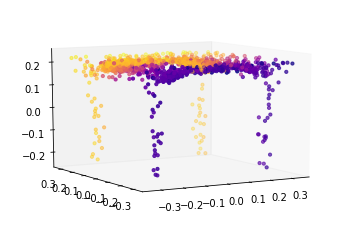

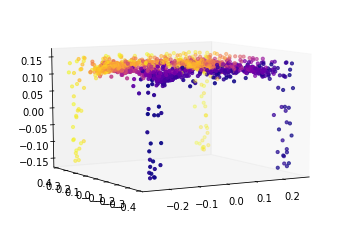

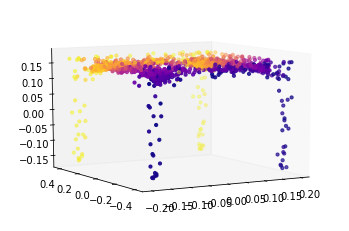

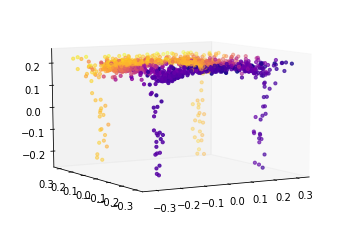

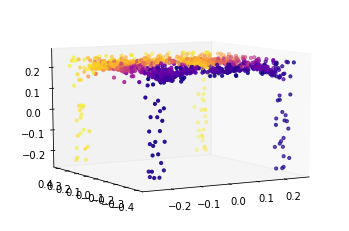

In [19]:
batch_idx, batch_data = next(enumerate(dataloader))
x = batch_data.pos.reshape(batch_size, n_points, 3).transpose(2, 1).cpu().detach().numpy()

# sample the noise vector:
z = torch.Tensor(batch_size, raw_gan_gen_input_dim).normal_(mu, sigma).to(device)
gen_samples = raw_gan_gen(z).cpu().detach().numpy()

print(x.shape)
print(gen_samples.shape)


for i in range(batch_size):
  visualize_points(gen_samples[i].transpose(1,0), is_shapenet=True)
  # visualize_real_and_generated_samples([x[i].transpose(1,0), gen_samples[i].transpose(1,0)], is_shapenet=True)